In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    

BATCH_SIZE = 64  # Increase batch size for better training
NUM_WORKERS = 4
DATA_DIR = "data"
DATA_DIR= Path("/n/home04/rrinberg/code/data_to_concept_unlearning/notebooks/data")
DATA_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/")
DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

BASE_DIR = Path("/n/home04/rrinberg/code/data_to_concept_unlearning/notebooks/")






DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [32]:
# ========================
# 2. DATA LOADING (WITH STRONG AUGMENTATION)
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)




Files already downloaded and verified


In [6]:
# load a model


def load_model(attr_index, models_dir, trial = 1, DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    SAVE_MODEL_PATH = f"resnet50_celeba__remove__{attr_index}__{trial}.pth"
    # resnet50_celeba__remove__31__0
    model_path = models_dir / SAVE_MODEL_PATH
    if not model_path.exists():
        raise ValueError(f"Model not found at {model_path}")
    
    model_without_attr = models.resnet50(pretrained=False)  # Train from scratch
    num_ftrs = model_without_attr.fc.in_features
    model_without_attr.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
    model_without_attr = model_without_attr.to(DEVICE)

    model_without_attr.load_state_dict(torch.load(model_path))
    
    return model_without_attr


model = load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [33]:
# validate the model on val set
from tqdm import tqdm   
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Threshold at 0.5 to get binary predictions

            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    preds = torch.cat(all_preds).cpu()
    labels = torch.cat(all_labels).cpu()
    return preds, labels
all_preds, all_labels = evaluate(model, val_loader)

100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


In [38]:
def get_TP_TN_FP_FN(col_ind, labels, predictions):
    # Get the false positives and false negatives for a specific attribute
    # where labels[:, col_ind] == 0 and predictions[:, col_ind] == 1
    FP = ((labels[:, col_ind] == 0) & (predictions[:, col_ind] == 1)).sum()
    FN = ((labels[:, col_ind] == 1) & (predictions[:, col_ind] == 0)).sum()
    TP = ((labels[:, col_ind] == 1) & (predictions[:, col_ind] == 1)).sum()
    TN = ((labels[:, col_ind] == 0) & (predictions[:, col_ind] == 0)).sum()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0 
    return (TP, TN, FP, FN), (precision, recall)


(TP, TN, FP, FN), _ = get_TP_TN_FP_FN(1, all_labels, all_preds)
TP, TN, FP, FN
# plot bar chart for each of the 40 attributes
import matplotlib.pyplot as plt
vals = [(get_TP_TN_FP_FN(i, all_labels, all_preds)[1]) for i in range(40)]
# plot
# plot bar chart of TP, TN, FP, FN for each attribute
import matplotlib.pyplot as plt
import numpy as np




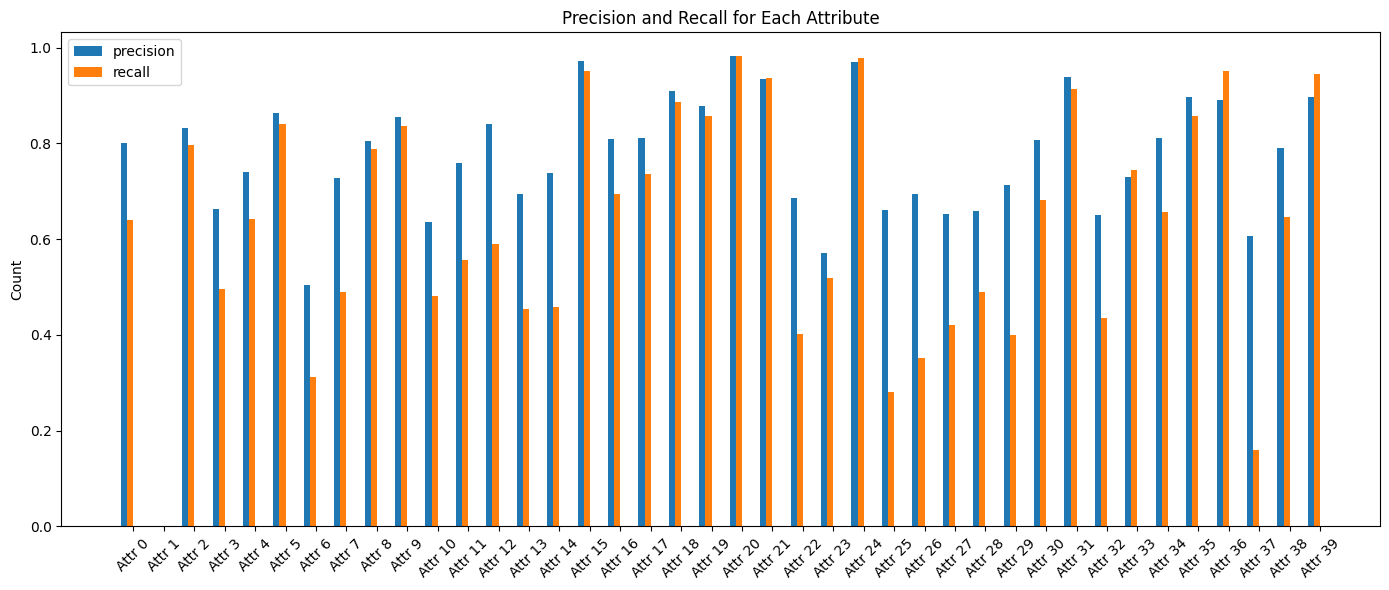

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Assume vals is a list of 40 tuples: (TP, TN, FP, FN)
# Example:
# vals = [(TP0, TN0, FP0, FN0), (TP1, TN1, FP1, FN1), ..., (TP39, TN39, FP39, FN39)]
def generate_precision_recall_chart(vals):
    vals_array = np.array(vals)  # shape will be (40, 4)

    # Number of attributes and categories
    num_attributes = vals_array.shape[0]
    categories = ['TP', 'TN', 'FP', 'FN']
    categories = ['precision' , 'recall']

    num_categories = len(categories)

    # x locations for each attribute group on the x-axis
    x = np.arange(num_attributes)

    # Width of each bar within a group (adjustable)
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 6))

    # Create a bar for each category in each group.
    ax.bar(x - 1.5*width, vals_array[:, 0], width, label='precision')
    ax.bar(x - 0.5*width, vals_array[:, 1], width, label='recall')
    #ax.bar(x + 0.5*width, vals_array[:, 2], width, label='FP')
    #ax.bar(x + 1.5*width, vals_array[:, 3], width, label='FN')

    # Set the x-axis ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels([f'Attr {i}' for i in range(num_attributes)], rotation=45)

    ax.set_ylabel('Count')
    ax.set_title('Precision and Recall for Each Attribute')
    ax.legend()

    plt.tight_layout()
    plt.show()

generate_precision_recall_chart(vals)

# no labels

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/20 [00:00<?, ?it/s]/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive w

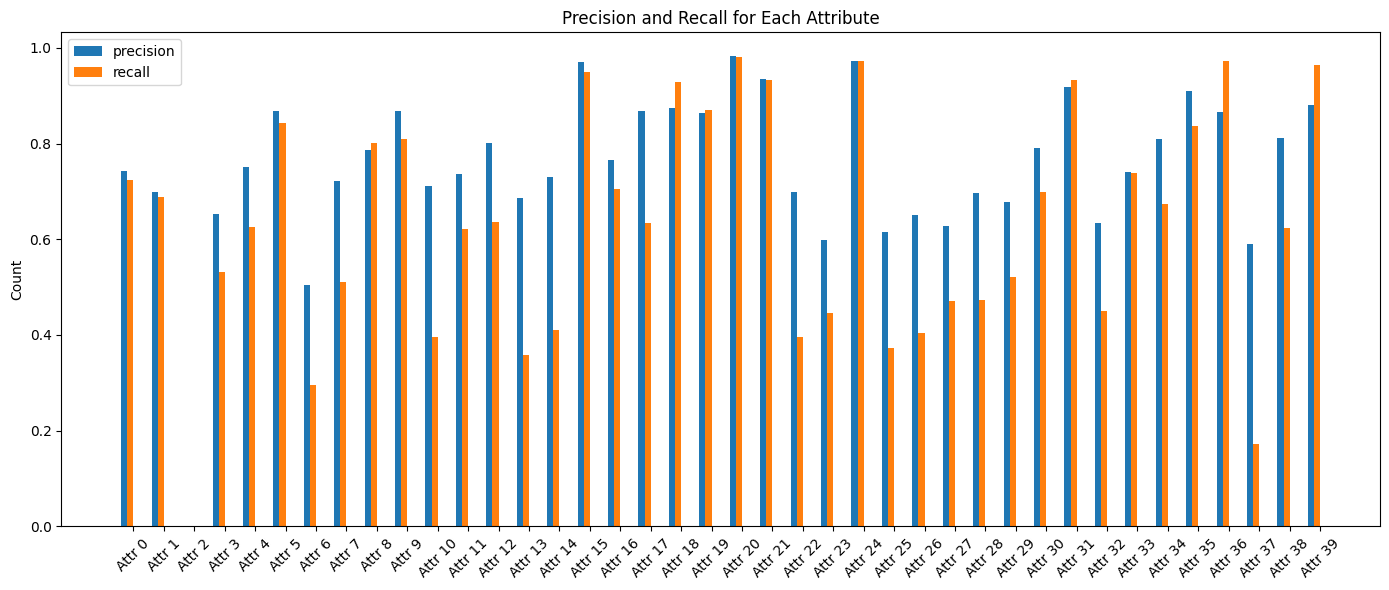

In [41]:

model = load_model(attr_index=2, models_dir=BASE_DIR / 
"models_without_labels__multiple", DEVICE = DEVICE)
all_preds, all_labels = evaluate(model, val_loader)
vals = [(get_TP_TN_FP_FN(i, all_labels, all_preds)[1]) for i in range(40)]
generate_precision_recall_chart(vals)


# no data

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/20 [00:00<?, ?it/s]/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive w

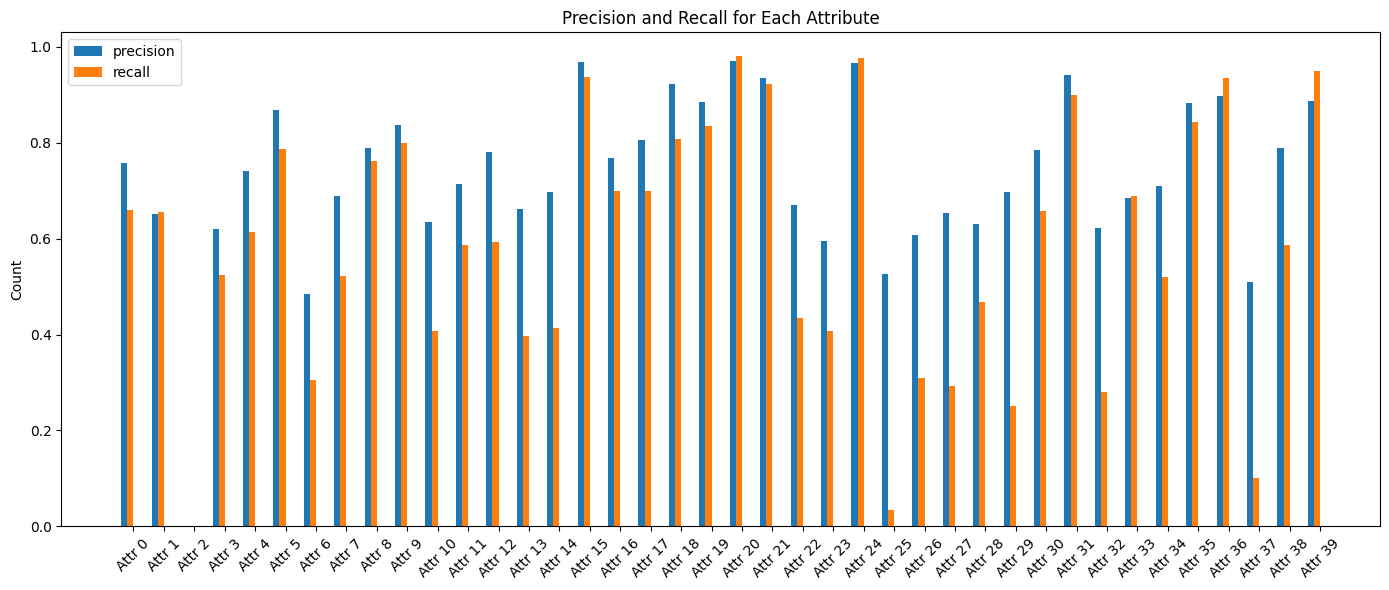

In [42]:
model = load_model(attr_index=2, models_dir=BASE_DIR / 
"models_without_data__multiple", DEVICE = DEVICE)
all_preds, all_labels = evaluate(model, val_loader)
vals = [(get_TP_TN_FP_FN(i, all_labels, all_preds)[1]) for i in range(40)]
generate_precision_recall_chart(vals)
